As we know, the police kill too many people. As the Washington Post points out, this number has not been going down:
> Despite the unpredictable events that lead to fatal shootings, police nationwide have shot and killed almost the same number of people annually — nearly 1,000 — since The Post began its project. Probability theory may offer an explanation. It holds that the quantity of rare events in huge populations tends to remain stable absent major societal changes, such as a fundamental shift in police culture or extreme restrictions on gun ownership.[^1]

[^1]: Source: https://www.washingtonpost.com/graphics/investigations/police-shootings-database/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import altair as alt




In [5]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv",
    parse_dates=["date"],
    index_col="date",
)

# df.to_csv("fatal-police-shootings-data.csv")

In [4]:

# importing washington post database from here: https://github.com/washingtonpost/data-police-shootings
df = pd.read_csv(
    "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv",
    parse_dates=["date"],
    index_col="date",
)


URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [3]:
df = pd.read_csv(
    "fatal-police-shootings-data.csv",
    parse_dates=["date"],
    index_col="date",
)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7871 entries, 2015-01-02 to 2022-11-02
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7871 non-null   int64  
 1   name                     7433 non-null   object 
 2   manner_of_death          7871 non-null   object 
 3   armed                    7660 non-null   object 
 4   age                      7374 non-null   float64
 5   gender                   7846 non-null   object 
 6   race                     6362 non-null   object 
 7   city                     7871 non-null   object 
 8   state                    7871 non-null   object 
 9   signs_of_mental_illness  7871 non-null   bool   
 10  threat_level             7871 non-null   object 
 11  flee                     6961 non-null   object 
 12  body_camera              7871 non-null   bool   
 13  longitude                7025 non-null   float64
 14  latitu

# recreating WaPo graphics

## Rate of shootings remains steady
1. plot one year of shootings as cumulativ

<AxesSubplot:>

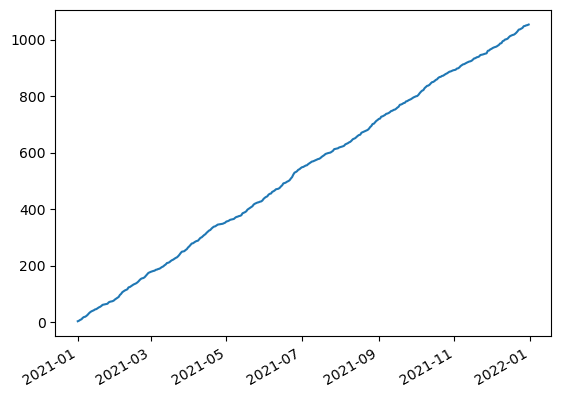

In [5]:
year2021 = df[df.index.year==2021]
year_count = year2021.index.value_counts().sort_index()
year_count.cumsum().plot()

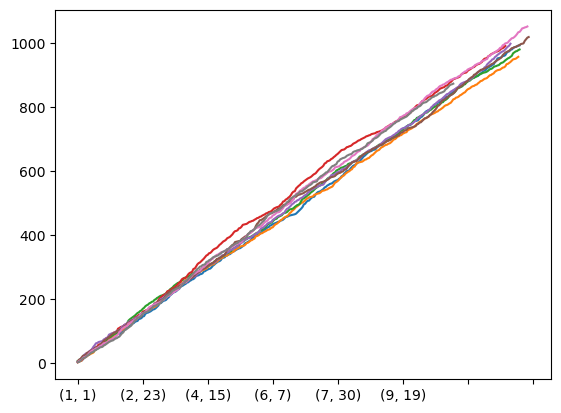

In [6]:
# here are all the years stacked on top of each other but the problem is I lost the granularity by day
for year in df.index.year.unique():
    df_year = df[df.index.year==year]
    year_count = df_year.index.value_counts().sort_index()
    year_count.index = ([year_count.index.to_series().dt.month, year_count.index.to_series().dt.day])
    year_count.cumsum().plot()

## 	- Racial breakdown - bad! 


<AxesSubplot:xlabel='race'>

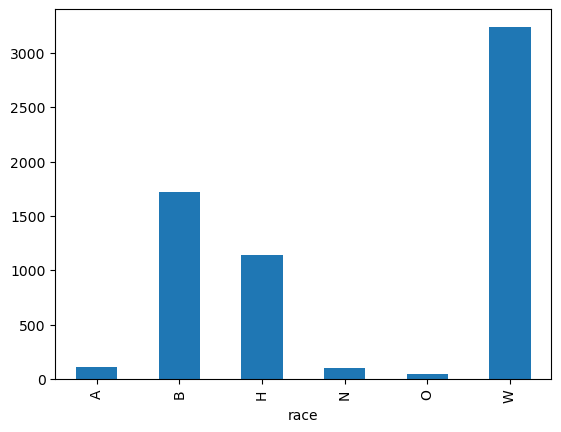

In [7]:
race = df.groupby("race").size()
race.plot(kind="bar")

In [24]:
racial = df.groupby(
    [df.index.year, df.index.month] #, df.race]
).size()
racial = racial[racial > 10]

In [25]:
# racial = racial.to_frame()
# racial.reset_index

racial = pd.DataFrame(
    racial,
)

# racial["full_date"] = (racial.columns[0], racial.columns[1])
racial.index

TypeError: __init__() got an unexpected keyword argument 'parse_dates'

In [ ]:
racial.plot()


In [13]:
import statsmodels.api as sm

pred = racial.index
target = racial
pred = sm.add_constant(pred) #If we do want to add a constant to our model — we have to set it by using the command X = sm.add_constant(X) where X is the name of your data frame containing your input (independent) variables.
# Note the difference in argument order
model = sm.OLS(target, pred).fit() # sm.OLS(output, input)
predictions = model.predict(pred) # make the predictions by the model

plt.scatter(racial.index,racial)
interc, coeff = model.params
# ci.append(model.params)

predicted = df.Age * coeff + interc
plt.plot(df.Age,predicted, color='purple')

#adding stems to be like that one on the site
plt.vlines(df.Age,predicted,df.Expenditures,linewidth=1)
# print(str(x) + " scale: " + str(model.scale))
# x+=1

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

##	- But unarmed - overall 


##	- By race 


# my charts

## yearly

### unarmed

In [26]:


# create dataframe for just the unarmed victims
unarmed = df[df.armed == "unarmed"]

# replace race keys with full words
unarmed.replace({"race": {
    "W": "White, non-Hispanic",
    "B": "Black, non-Hispanic",
    "A": "Asian",
    "N": "Native American",
    "H": "Hispanic",
    "O": "Other",
    "None": "unknown"
}}, inplace=True
)

# group by year
killings_yearly_unarmed = unarmed.groupby(
    [unarmed.index.year, unarmed.race]
).size(
).rename("Number Killed")

kyearly = pd.DataFrame(killings_yearly_unarmed).reset_index()



/var/folders/xf/hvmt2df550v3bwqbms0tskbm0000gn/T/ipykernel_85340/928498616.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### tooltip

In [27]:
# multiline tooltip
# from https://altair-viz.github.io/gallery/multiline_tooltip.html

# Create a selection that chooses the nearest point & selects based on x-value
# it wasn't on the line because it was doing interpolate basis which draws a nice curvy polynomial line between the points
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['date'], empty='none')

# The basic line
line = alt.Chart(kyearly).mark_line().encode(
    x='date:O',
    y='Number Killed:Q',
    color='race:N',
    # tooltip=['Number Killed', 'race']
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(kyearly).mark_point().encode(
    x='date:O',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Number Killed:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(kyearly).mark_rule(color='gray').encode(
    x='date:O',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, text, rules
).properties(
    width=400, height=300
)




alt.LayerChart(...)

### all

<AxesSubplot:xlabel='date', ylabel='0'>

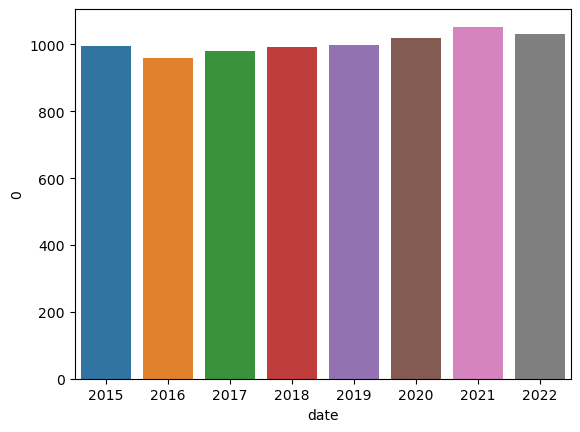

In [13]:
# plotting killings per year
killings_yearly = df.groupby(df.index.year).size()
killings_yearly

# account for 2022 being not done 
from datetime import date

percent_2022 = (date.today() - date(2022, 1, 1)).days/365
killings_yearly[2022] = killings_yearly[2022] / percent_2022
killings_yearly = killings_yearly.to_frame()

#plot
sns.barplot(
    data=killings_yearly,
    x=killings_yearly.index, y=killings_yearly[0]
    )


In [14]:
import plotly.express as px
import statsmodels.formula.api as smapi
import plotly.graph_objects as go





In [15]:
fig = px.bar(
    killings_yearly, 
    x=killings_yearly.index, y=killings_yearly[0]
)
fig.show()


In [16]:
killings_yearly, killings_yearly.index

(                0
 date             
 2015   994.000000
 2016   958.000000
 2017   981.000000
 2018   992.000000
 2019   999.000000
 2020  1020.000000
 2021  1053.000000
 2022  1032.394822,
 Int64Index([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], dtype='int64', name='date'))

<AxesSubplot:xlabel='date'>

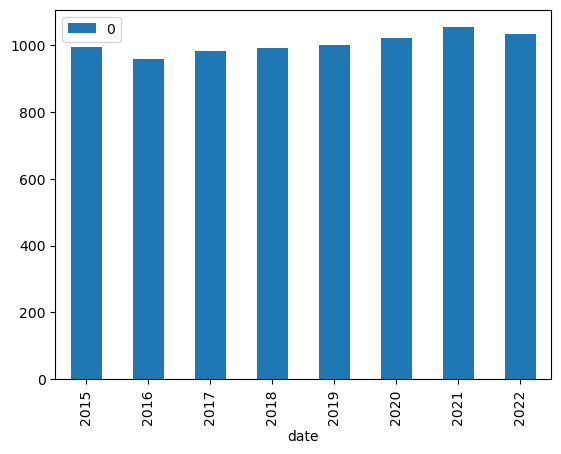

In [17]:
# in plt
killings_yearly.plot(kind="bar")
